# Linear Regression

## Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Data imputation
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import dengue_utils as dutils

import xgboost as xgb

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
# Functions:

def simple_linear_regression(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=83)
    
    reg = LinearRegression(normalize=True).fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ex_var = explained_variance_score(y_test, y_pred)
    
    return mae, r2, ex_var

def enet(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=83)

    reg = ElasticNet(normalize=False).fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    
    return y_pred, y_test

def get_metrics(y_test, y_pred):
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ex_var = explained_variance_score(y_test, y_pred)
    
    return mae, r2, ex_var

def feature_engineering(df):## Add month of the year

    print("1. Including month of the year from 'week_start_date....'")
    
    if 'week_start_date' in df.columns:
        df['week_start_date'] = pd.to_datetime(df['week_start_date'])
        #df['monthofyear'] = df['week_start_date'].apply(lambda x: x.month)
        
        df = df.drop(['week_start_date'], axis=1)

    # High correlation between ndvi_nw-ndvi-ne and ndvi-sw-ndvi-se
    # Add the mean of each pair that indicates the level of vegetation in the north and south of both cities.

    # Features engineering
    print("2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... ")
    
    if 'ndvi_nw' in df.columns and 'ndvi_ne' in df.columns and 'ndvi_sw' in df.columns and 'ndvi_se' in df.columns:
    
        df['ndvi_north'] = df[['ndvi_nw', 'ndvi_ne']].mean(axis=1)
        df['ndvi_south'] = df[['ndvi_sw', 'ndvi_se']].mean(axis=1)
        
        df = df.drop(['ndvi_sw', 'ndvi_nw', 'ndvi_ne', 'ndvi_se'], axis=1)

    # Conversion kelvin to celsius
    print("3. Temperature units conversion: kelvin to celsius from some features...")
    df = dutils.temperature_conversion(df)
    
    # City to numeric
    
    df['city_code'] = np.where(df['city'] == 'sj', 0, 1)
    # Drop temperature features
   # df = df.drop(['reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c', 
   #               'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c',
   #               'reanalysis_avg_temp_c', 'reanalysis_tdtr_c', 'station_max_temp_c',
   #               'station_max_temp_c', 'station_diur_temp_rng_c', 'station_avg_temp_c',
   #              'station_min_temp_c', 'reanalysis_specific_humidity_g_per_kg'], axis=1)
   # 
    return df


In [22]:
# Load dataset

features_train = pd.read_csv('dengue_features_train.csv')
labels_train   = pd.read_csv('dengue_labels_train.csv')

features_test = pd.read_csv('dengue_features_test.csv')

# Join train labes and features
input_train_dataset = features_train.merge(labels_train, 
                                           left_on = ['city', 'year', 'weekofyear'], 
                                           right_on = ['city', 'year', 'weekofyear'],
                                           how = 'inner')



In [23]:
input_train_dataset.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [24]:
input_train_dataset['week_start_date'] = pd.to_datetime(input_train_dataset['week_start_date'])
input_train_dataset.dtypes

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

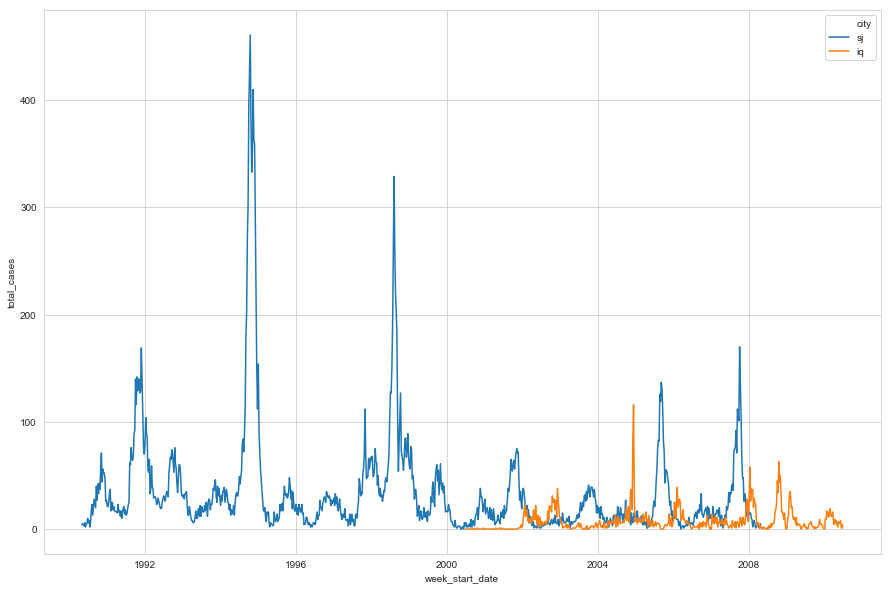

In [25]:
f, ax = plt.subplots(figsize=(15, 10))

# Plot the responses for different events and regions
sns.lineplot(x="week_start_date", y="total_cases", hue="city",
             data=input_train_dataset)

In [26]:
print(input_train_dataset[input_train_dataset['city'] == 'iq']['week_start_date'].max())
print(input_train_dataset[input_train_dataset['city'] == 'iq']['week_start_date'].min())

2010-06-25 00:00:00
2000-07-01 00:00:00


In [27]:
print(input_train_dataset[input_train_dataset['city'] == 'sj']['week_start_date'].max())
print(input_train_dataset[input_train_dataset['city'] == 'sj']['week_start_date'].min())

2008-04-22 00:00:00
1990-04-30 00:00:00


In [28]:
input_train_dataset = input_train_dataset[input_train_dataset['week_start_date'] >= '2000-07-01']
input_train_dataset = input_train_dataset[input_train_dataset['week_start_date'] <= '2008-04-22']

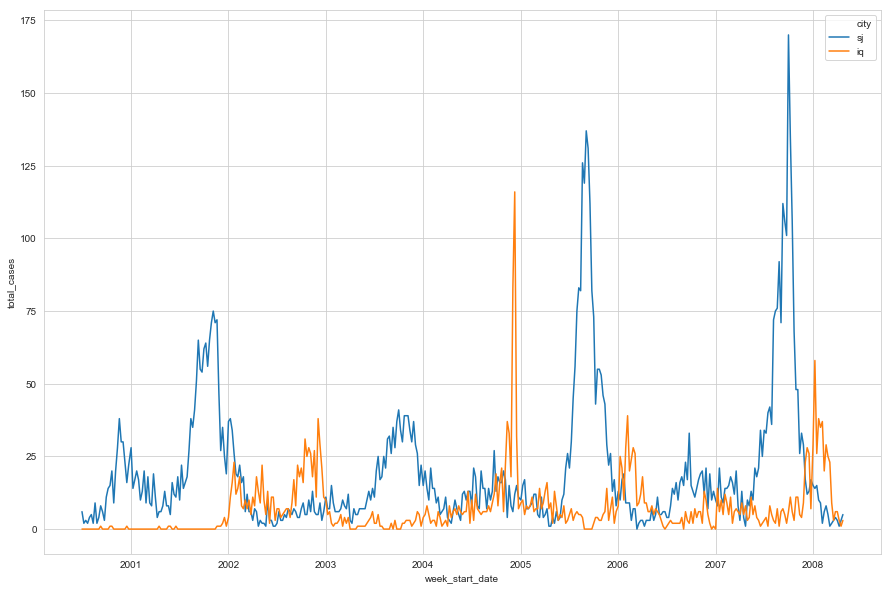

In [29]:
f, ax = plt.subplots(figsize=(15, 10))

# Plot the responses for different events and regions
sns.lineplot(x="week_start_date", y="total_cases", hue="city",
             data=input_train_dataset)

## Preprocessing

In [30]:
def preprocessing(dataset, train=True):
    # --------------------------------------
    # Feature engineering
    #---------------------------------------

    dataset = feature_engineering(dataset)
    label = 'total_cases'

    # --------------------------------------
    # Remove outiers
    #---------------------------------------

    # Remove outliers
    for feature in  dataset.columns:
        dataset[feature] = dutils.remove_outliers_iqr(dataset, feature, exclude = ['total_cases'])

    dutils.printlog("Remove outliers " + str(dataset.shape)) 
    # Filling the outliers gaps
    #dataset = dataset.dropna().drop_duplicates()

    # --------------------------------------
    # Split data and label
    #---------------------------------------

    dataset_label = []
    if label in dataset.columns:
        # Split label and features
        dataset_label  = dataset[label].copy()
        dataset = dataset.drop([label], axis=1)

    # Drop city column because is not numeric and label column (total_cases)
    features_lreg = dataset.columns.drop(['city'])

    dataset = dataset[features_lreg]

    # --------------------------------------
    # Scaling and data imputation
    #---------------------------------------

    # Data imputation
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    dataset_train_imp = pd.DataFrame(imp.fit_transform(dataset))

    dutils.printlog("Data imputation " + str(dataset.shape)) 

    # Set columns name
    dataset_train_imp.columns = dataset.columns
    dataset_train_imp.index   = dataset.index


    # Scale data (features)
    scaler = StandardScaler().fit(dataset_train_imp)
    dataset = pd.DataFrame(scaler.transform(dataset_train_imp), columns = dataset_train_imp.columns)

    dutils.printlog("Scale " + str(dataset.shape)) 
    
    if train:
        dataset_label = dataset_label.reset_index()
        dataset_label = dataset_label['total_cases']
        dataset['total_cases'] = dataset_label.copy()
        
    return dataset

In [31]:
dutils.printlog("Preprocessing " + str(input_train_dataset.shape)) 
dataset_train = preprocessing(input_train_dataset)
dataset_label = dataset_train['total_cases']
dataset_train = dataset_train.drop('total_cases', axis=1)
dataset_train.describe().T

20190415 - 01:M:34: Preprocessing (814, 25)
1. Including month of the year from 'week_start_date....'
2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... 
3. Temperature units conversion: kelvin to celsius from some features...
20190415 - 01:M:34: Temperature conversion: kelvin to celsius reanalysis_air_temp_k to reanalysis_air_temp_c
20190415 - 01:M:34: Temperature conversion: kelvin to celsius reanalysis_dew_point_temp_k to reanalysis_dew_point_temp_c
20190415 - 01:M:34: Temperature conversion: kelvin to celsius reanalysis_max_air_temp_k to reanalysis_max_air_temp_c
20190415 - 01:M:34: Temperature conversion: kelvin to celsius reanalysis_min_air_temp_k to reanalysis_min_air_temp_c
20190415 - 01:M:34: Temperature conversion: kelvin to celsius reanalysis_avg_temp_k to reanalysis_avg_temp_c
20190415 - 01:M:34: Temperature conversion: kelvin to celsius reanalysis_tdtr_k to reanalysis_tdtr_c
20190415 - 01:M:34: Remove outliers (814, 24)
20190415 - 01:M:34: 

,count,mean,std,min,25%,50%,75%,max
year,814.0,4.391028e-14,1.000615,-1.705518,-0.833475,3.856698e-02,0.910609,1.782652
weekofyear,814.0,2.427760e-17,1.000615,-1.690689,-0.896257,3.058010e-02,0.891215,1.751849
precipitation_amt_mm,814.0,4.266994e-16,1.000615,-1.277822,-0.849103,-9.654128e-02,0.683250,3.075228
reanalysis_precip_amt_kg_per_m2,814.0,2.455039e-18,1.000615,-1.297124,-0.798114,-1.807172e-01,0.490635,3.055773
reanalysis_relative_humidity_percent,814.0,-1.474933e-15,1.000615,-3.163401,-0.763605,-3.284125e-01,0.911369,1.986010
reanalysis_sat_precip_amt_mm,814.0,4.266994e-16,1.000615,-1.277822,-0.849103,-9.654128e-02,0.683250,3.075228
reanalysis_specific_humidity_g_per_kg,814.0,9.709678e-16,1.000615,-3.130746,-0.792783,2.496413e-01,0.816052,1.944830
station_avg_temp_c,814.0,-1.746214e-15,1.000615,-2.879102,-0.617476,1.281822e-01,0.732104,2.395971
station_diur_temp_rng_c,814.0,2.673264e-16,1.000615,-1.748660,-0.848042,-2.204838e-01,0.831834,3.290969
station_max_temp_c,814.0,-9.512934e-16,1.000615,-2.307185,-0.645804,6.881640e-03,0.659567,2.558288


## Training models

In [32]:
# --------------------------------------
# Split dataset in test and training
#---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(dataset_train, 
                                                    dataset_label, 
                                                    test_size = 0.2, 
                                                    random_state=83)

# --------------------------------------
# Training models
#---------------------------------------

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=83)
xgb_model = xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test).astype(int)

(8.687116564417177, 0.4750637121669615, 0.487446829347439)


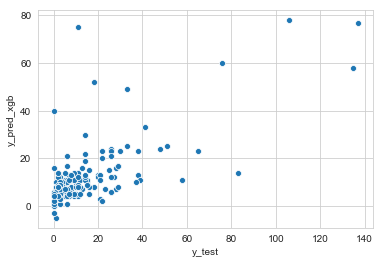

In [33]:
metrics_xgb = get_metrics(y_test, y_pred_xgb)
print(metrics_xgb)

df_test = pd.DataFrame(list(y_test), columns=['y_test'])
y_pred_xgb = pd.DataFrame(list(y_pred_xgb), columns=['y_pred_xgb'])

df = pd.concat([df_test, y_pred_xgb], axis=1)


ax = sns.scatterplot(x="y_test", y="y_pred_xgb", data=df)

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.grid_search import GridSearchCV

print('XGBoost with grid search')
# play with these params
params={
    'max_depth': [2], #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [1000], #[1000,2000,3000]
    'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}

xgb_res = xgb.XGBRegressor(objective="reg:linear", random_state=83)

parameters = {'nthread':[2], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.03, 0.05, 0.07], #so called `eta` value
              'max_depth': [3, 4, 5, 6, 7],
              'min_child_weight': [4, 5, 6],
              'silent': [1],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_res,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)

metrics_xgb = get_metrics(y_test, y_pred_xgb)
print(metrics_xgb)

# Roc AUC with all train data


XGBoost with grid search
Fitting 2 folds for each of 405 candidates, totalling 810 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   32.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 810 out of 810 | elapsed:  2.5min finished


(8.43624902844429, 0.5287606759268857, 0.5296470698703839)


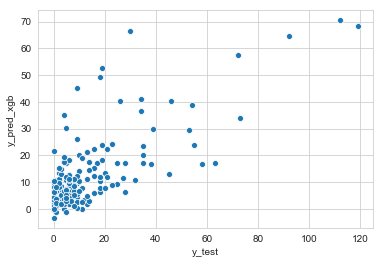

In [18]:
df_test = pd.DataFrame(list(y_test), columns=['y_test'])
y_pred_xgb = pd.DataFrame(list(y_pred_xgb), columns=['y_pred_xgb'])

df = pd.concat([df_test, y_pred_xgb], axis=1)


ax = sns.scatterplot(x="y_test", y="y_pred_xgb", data=df)

In [19]:
features_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [20]:
dutils.printlog("Preprocessing " + str(features_test.shape)) 
dataset_test = preprocessing(features_test, train=False)
y_predictions = xgb_grid.best_estimator_.predict(dataset_test)
features_test['total_cases'] = np.round(y_predictions).astype(int)

features_test.head()

20190415 - 01:M:08: Preprocessing (416, 24)
1. Including month of the year from 'week_start_date....'
2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... 
3. Temperature units conversion: kelvin to celsius from some features...
20190415 - 01:M:08: Temperature conversion: kelvin to celsius reanalysis_air_temp_k to reanalysis_air_temp_c
20190415 - 01:M:08: Temperature conversion: kelvin to celsius reanalysis_dew_point_temp_k to reanalysis_dew_point_temp_c
20190415 - 01:M:08: Temperature conversion: kelvin to celsius reanalysis_max_air_temp_k to reanalysis_max_air_temp_c
20190415 - 01:M:08: Temperature conversion: kelvin to celsius reanalysis_min_air_temp_k to reanalysis_min_air_temp_c
20190415 - 01:M:08: Temperature conversion: kelvin to celsius reanalysis_avg_temp_k to reanalysis_avg_temp_c
20190415 - 01:M:08: Temperature conversion: kelvin to celsius reanalysis_tdtr_k to reanalysis_tdtr_c
20190415 - 01:M:08: Remove outliers (416, 22)
20190415 - 01:M:08: 

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,5
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,8
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,4
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,5
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,1


In [21]:
features_test[['city', 'year', 'weekofyear', 'total_cases']].to_csv("./submission_20190415.csv", index=False)

## PCA

https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/
    

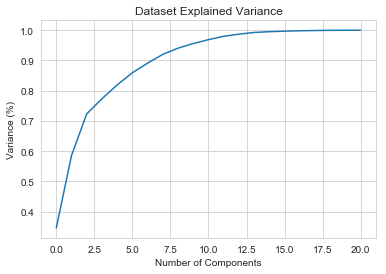

In [22]:
from sklearn.decomposition import PCA

pca = PCA()

principalComponents = pca.fit_transform(dataset_train)
principalDf = pd.DataFrame(data = principalComponents)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [23]:
pca = PCA(n_components=12)
dataset_train = pca.fit_transform(dataset_train)
#dataset = pd.DataFrame(dataset, columns = ['pca_comp1', 'pca_comp2', 'pca_comp3', 'pca_comp4', 'pca_comp5'])
dataset_train.shape

(874, 12)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dataset_train, 
                                                    dataset_label, 
                                                    test_size = 0.2, 
                                                    random_state=83)

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=83)
xgb_model = xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

metrics_xgb = get_metrics(y_test, y_pred_xgb)
print(metrics_xgb)



(8.877666088172367, 0.48799622112883423, 0.4890925276729037)
